In a previous notebook, we have shown how to [fit a psychometric curve using pyTorch](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html). Here, I would like to review some nice properies of the logistic regression model (WORK IN PROGRESS). 

<!-- TEASER_END -->

Let's first initialize the notebook:

# quelques définitions

## initialisation du notebook

Nous allons importer quelques librairies qui seront utilisées pour la manipulation numérique de matrices et l'affichage:

In [8]:
import time
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

## Définition des variables et fonctions

... utiles pour réaliser une classification  de données synthétiques selon une régression logistique

In [9]:
N = 256 # nombre de valeurs de l'entrée
n_classes = 10 # nombre de classes
N_batch = 100 # nombre d'échantillons
seed = 1973
fig_width = 10
phi = np.sqrt(5)/2 + 1/2
figsize = (fig_width, fig_width/phi)

np.random.seed(seed)
W = np.random.randn(N+1, n_classes) # FIXED design matrix of weights (w) according to classes
X = np.random.randn(N_batch, N)

def get_data(W, X, seed, N_batch):
    N, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    # nos entrées (X) : n_batch échantillons comprenant chacun N valeurs
    # tirage de causes aléatoires
    X = np.random.randn(N_batch, N) 
    # modèle génératif: mélange
    e = (X @ W[:-1, :]) + W[-1, :] 
    p = 1 / (1 + np.exp(-e))
    # Tirage de Bernoulli : si p > à random => 1, si p < à random = 0 
    y = p > np.random.rand(N_batch, n_classes) # Bernoulli, generate data 
    return X, p, y, e

In [10]:
X, p, y, e = get_data(W, X, seed, N_batch)

Avec __X,p,y = get_data(W, seed, N_batch)__ on appelle la fct get_data, qui appelle la fonction `sigmoid`, qui appelle la fonction evidence afin de nous renvoyer les entrées X (100 entrées, comprenant chacune 256 valeures), les probabilités de classification de ces différentes entrées dans les différentes classes (p), et la classification après tirage de bernoulli (y = succès si p > 0.5, echcec si p < 0.5). Pour visualiser les sorties (p et y) en fonction des entrées (X et e), on les stock dans des arrays. 

## Visualisation des données

Visualisation de p en fonction de e pour une classe :

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1],p[:,1]) 

Visualisation de p en fonction de e pour une classe + de la sortie (tirage de Bernoulli = y) 

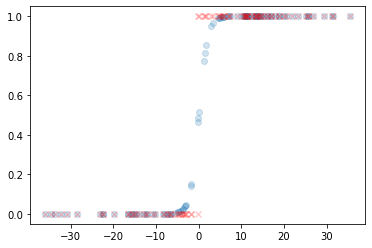

In [12]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1],p[:,1], alpha=.2) #proba de e d'être classifié dans classe 1
ax.scatter(e[:,1],y[:,1], alpha=.2, marker="x", color="red") #Sortie de Bernoulli 

Visualisation de la distribution des probabilités de classification 

(array([432.,  14.,  13.,  11.,   8.,   9.,   8.,  15.,  20., 470.]),
 array([2.91404343e-24, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

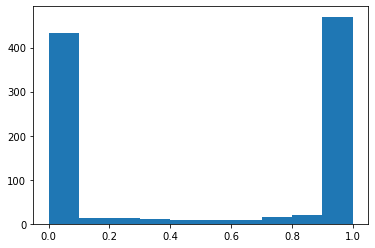

In [13]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(p.ravel(), bins=10)

Visualisation de p en fonction de chaque entrée X + de la sortie y  'permise' par l'ajout des w et biais 

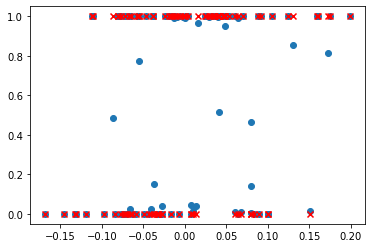

In [20]:
X_1 = np.mean(X,1)
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(X_1,p[:,1]) 
ax.scatter(X_1,y[:,1],marker="x", color="red")

... la situation est plus confuse... est-ce quon va arriver à distinguer les différents cas?

# Inversion

## Définition du réseau d'inversion

In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size//the sum of the output will be divided by the number of elements in the output
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output 

class LogisticRegressionModel(torch.nn.Module):
    
    # voir ce que signifie self 
    # voir ce que signifie super 
    
    def __init__(self, N, n_classes, bias=True): # (self, input_dim, output_dim)
        super(LogisticRegressionModel, self).__init__() 
        
        # 1ere couche : self.linear = torch.nn.Linear(input_dim, output_dim, bias=true) bias = true pour apprentissage
        self.linear = torch.nn.Linear(N, n_classes, bias=bias) 
        
        # 2e couche : self.nl = torch.nn.Sigmoid() = ouputs 
        # autre possibilité : self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()
    
    # maintenant qu'on a difinit les couches, on 
    # self.nl me donne la sigmoïde de e 
    # X = (N, n_batch) là on est dans 1 batch donc X = 256 = N 
    
    def forward(self, X):
        return self.nl(self.linear(X))

 __init__ permet de définir notre NN, les couches, leur role, la dimention des entrées et sorties
 
On a un réseau composé de deux couches : 
- la première (self.linear) réalise une transformation linéaire de nos entrées X (de dimention N =  256) de sorte à ce que la sortie y = (w*x)+biais = e (de dimention n_classes = 10). Une entrée sera associée aux différentes classes avec un w et un biais associé pour chacune des classes. Après plusieurs batch, on obtiendra plusieurs e pour la même ent alors plusieurs e pour chaque classes.
    
- la deuxième (self.nl) transforme ces sorties (e) pour leur donner une distribution sigmoïde. On obtient ainsi la probabilité de classification de l'entrée X, associée à un poid w et au biais. On aura n_classes sigmoïdes, représentant la probabilité de classification de l'entrée dans chacune des classes en fonction du w et du biais associé. 

La fonction __forward__ permet de construire le réseau en connectant les couches selon un modèle forward : self.nl(self.linear(X))

Par la suite, le réseau va modifier ses paramètres : w et biais de sorte à ce que la classification des X se fasse de la même manière que pendant l'initialisation

-> Pour cela, on demande à notre réseau de calculer la loss function entre la classification réalisée par self.nl(self.linear(X)) et celle réalisée par y 

-> Plus la différence est grande, plus la loss function l'est aussi et plus le réseau va modifier ses paramètres (W et biais) pour classifier de la même façon que pdt l'initialisation 

-> On devrait donc retrouver à la fin des W et des biais similaires entre ceux fixés par nous pendant l'initialisation et ceux déterminés par le réseau pdt l'inversion 


In [22]:
logistic_model = LogisticRegressionModel(N,n_classes) #(input_dim, output_dim)

In [23]:
bias_before_training = logistic_model.linear.bias
w_before_training = logistic_model.linear.weight
#bias_before_training.shape # shape = 10 car 1 biais associé à une classe, pour tous les x 
#w_before_training.shape # shape =  ([10, 256]) car pour chaque classe, on attribue 1 poid à chaque X

## Définition des variables d'apprentissage, d'entrée et de sortie

In [24]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

batch_size = 100
n_classes= 10

X = torch.randn(N_batch, N)
outputs = logistic_model(X)


## Défition des fonctions pour l'apprentissage des w et biais pour classification

In [25]:
def fit_data(X, y, learning_rate=learning_rate,batch_size=batch_size,num_epochs=num_epochs,betas=betas,verbose=False, **kwargs):

    X_0 = torch.Tensor(X[:, None]) # rajoute une dimention de taille 1 : pk ? 
    labels = torch.Tensor(y[:, None]) # remplace les True/False par des 1 et 0, rajoute une dimention de taille 1 : pk ? 
    
    loader = DataLoader(TensorDataset(X_0, labels), batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = X.shape[0] # = 100
    N = X.shape[1] # = 256 
    n_classes = y.shape[1] # = 10
    
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
    for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
        logistic_model.train()
        losses = [] 
        for X_, labels_ in loader: 
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)  
            loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
            
            losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    logistic_model.eval()
    X_0, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None]) #utile ? 
    outputs = logistic_model(X_0) #utile ? 
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

Dans la fonction __fit_data__ :
- On commence par __définir les variables d'intéret et l'optimizer__. Lors de la définition de l'optimizer, on lui indique __quel paramètre il doit modfier__ pendant l'apprentissage et le learning rate. Ici les paramètres modifiés par l'optimizer sont les poids et biais associés aux entrées pour les différentes classes. L'optimizer Adam va modifier le poid et le biais des différentes classes pour que la classfication des entrées soit similaire à celle obtenue pendant l'initialisation. Pour cela, il fait ........... . La particularité de cet optimizer est qu'il diminue le learning rate en même temps que la différence diminue. Le learning rate correspond au nombre de pas necessaire pour atteindre le minimum de loss function- à approfondir - 

- En suite, __on commence l'entrainement__ à partir des données comprises dans loader (= X_0, labels // équivalent à : N_batch entrées de N valeurs (= X) et N_batch sorties de n_classes valeurs (= y)). Dans un premier temps, on prend les X, on les fait passer dans le logistic_model et on récupère dans outputs les probabilités de classification des N_batch entrées. Ensuite, on compare la classification effectuée par le logistic_model avec celle effectuée dans l'iniitialisation. Le criterion calcule la différence entre les deux par le calcule de la BCE et on stock cette différence dans loss. L'optimizer va modifier les w et biais associés aux entrées pour les différentes classes de sorte à diminuer au plus possible la loss function au cours de différentes iterations. 

- On demande d'imprimer les loss_function toutes les itérations multiples de 32 

- ensuite on passe au __test du logistic_model__ et on renvoit la probabilté de classification des n_batch entrées ainsi que la loss_function après apprentissage des poids et biais optimaux pour que la classification se fasse comme dans l'initialisation. 

__On devrait ainsi obtenir des poids et biais similaires à ceux définis dans l'inialisation : C'est l'inversion__ 

On appelle la fonction get_data pour qu'elle nous renvoit les X, p et y.
On appelle la fonction fit_data pour réaliser l'apprentissage des w et biais et la classification et qu'elle nous renvoit le modele logistic entrainé et les pertes au cours de l'apprentissage et après l'apprentissage. 

In [26]:
X, p, y, e = get_data(W, X, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(X, y, verbose=True)
#print("Final loss =", loss)

Iteration: 0 - Loss: 0.42395
Iteration: 16 - Loss: 0.09862
Iteration: 32 - Loss: 0.08507
Iteration: 48 - Loss: 0.07991
Iteration: 64 - Loss: 0.07710
Iteration: 80 - Loss: 0.07550
Iteration: 96 - Loss: 0.07450
Iteration: 112 - Loss: 0.07379
Iteration: 128 - Loss: 0.07303
Iteration: 144 - Loss: 0.07261
Iteration: 160 - Loss: 0.07245
Iteration: 176 - Loss: 0.07227
Iteration: 192 - Loss: 0.07193
Iteration: 208 - Loss: 0.07178
Iteration: 224 - Loss: 0.07169
Iteration: 240 - Loss: 0.07166
Iteration: 256 - Loss: 0.07145
Iteration: 272 - Loss: 0.07139
Iteration: 288 - Loss: 0.07137
Iteration: 304 - Loss: 0.07131
Iteration: 320 - Loss: 0.07123
Iteration: 336 - Loss: 0.07124
Iteration: 352 - Loss: 0.07119
Iteration: 368 - Loss: 0.07119
Iteration: 384 - Loss: 0.07107
Iteration: 400 - Loss: 0.07102
Iteration: 416 - Loss: 0.07104
Iteration: 432 - Loss: 0.07106
Iteration: 448 - Loss: 0.07106
Iteration: 464 - Loss: 0.07100
Iteration: 480 - Loss: 0.07105
Iteration: 496 - Loss: 0.07109
Iteration: 512 -

In [27]:
bias_after_training = logistic_model.linear.bias
w_after_training = logistic_model.linear.weight

In [28]:
print('BIAIS')
print('before training,', bias_before_training)
print('after training,', bias_after_training) 
print('initialisation', W[-1, :])

BIAIS
before training, Parameter containing:
tensor([-0.0337,  0.0408, -0.0137,  0.0220, -0.0200,  0.0296,  0.0297, -0.0087,
        -0.0388,  0.0599], requires_grad=True)
after training, Parameter containing:
tensor([ 1.5442,  0.2597, -0.1811,  2.9585, -0.2349,  3.0877,  2.3522, -0.5201,
         1.6290, -2.7351], requires_grad=True)
initialisation [ 1.22476992  0.1665627  -0.17190827  2.38852104 -0.2641366   2.56468991
  2.00251814 -0.45923941  1.40249567 -2.0906894 ]


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=figsize)
ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
ax.plot(W[-1, :], 'b--')

In [30]:
print('WEIGHT')
print('before training,', w_before_training)
print('after training,', w_after_training) 
print('initialisation : ', W[:-1,:].T)

WEIGHT
before training, Parameter containing:
tensor([[-0.0553,  0.0105, -0.0393,  ...,  0.0606,  0.0352, -0.0131],
        [-0.0251,  0.0609,  0.0417,  ...,  0.0268, -0.0111, -0.0174],
        [ 0.0368, -0.0417,  0.0450,  ..., -0.0402,  0.0457, -0.0287],
        ...,
        [-0.0464, -0.0313,  0.0381,  ..., -0.0622, -0.0074, -0.0399],
        [-0.0566, -0.0117,  0.0466,  ...,  0.0314,  0.0073,  0.0545],
        [ 0.0267,  0.0107,  0.0063,  ..., -0.0589,  0.0130, -0.0299]],
       requires_grad=True)
after training, Parameter containing:
tensor([[-2.2178, -1.0385,  0.9953,  ...,  0.3877,  0.7035, -0.3211],
        [-0.0121, -0.5888, -0.3252,  ...,  0.5136,  0.5469, -1.0451],
        [-0.9520, -0.1423,  0.2694,  ...,  1.0224, -0.6208,  0.2212],
        ...,
        [ 0.2661, -2.0182, -0.9302,  ...,  0.5501,  1.9832,  0.0078],
        [-0.5350,  0.9421, -1.6948,  ..., -1.4671, -0.0521, -0.3756],
        [ 1.0967,  0.7207, -0.4141,  ..., -0.3909,  1.6609,  2.1183]],
       requires_grad=

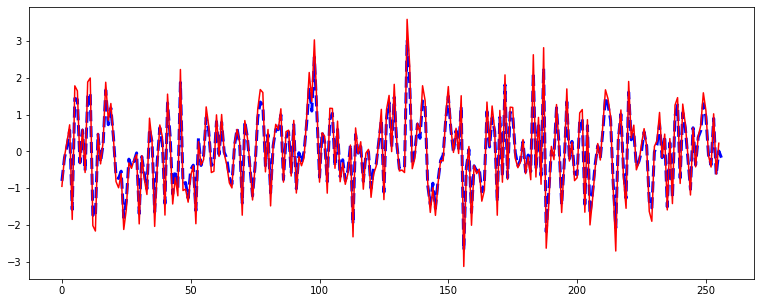

In [31]:
i_digit = 2
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[:, i_digit], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

On voit que les biais et les poids ont changé après l'apprentissage pour se rapprocher de ceux de l'intialisation

# Un modele réaliste de courbes d'accord

## Définition de probabilités de firing des neurones, par classe

je viens de modifier N et K pour aller plus vite, faire en sorte que les proba soient directement définis à partir des N et n_classes and stuff, à arranger encore 

In [ ]:
N_trials = 2**11 # number of trials
p_1 = .01 # average firing probability
sigma = .51 # bandwidth

N = 256 # nombre de valeurs de l'entrée
n_classes = 10 # nombre de classes
N_batch = 100 # nombre d'échantillons
seed = 1973


# a simple circular function to generate patterns 
def von_mises(j, N, sigma):
    p_ = np.exp( np.cos(2*np.pi* (np.linspace(0, 1, N, endpoint=False) -j/N)) / sigma**2)
    p_ /= p_.sum()
    return p_
 
def stack(n_classes, N, sigma):
    p_ = np.zeros((N, n_classes))
    for classe in range(n_classes):
        p_[:, classe] = von_mises(classe*N/n_classes, N, sigma)
    return p_

p_true = stack(n_classes, N, sigma)

N_hyp = p_true.shape[-1] 
fig, ax = plt.subplots(1, 1, figsize=figsize) #fig, ax = plt.subplots(nb de plot, nb de x, taille de l'image largeur, longueur)
for i_test in range(N_hyp):
    ax.step(np.arange(N), (p_true[:, i_test].T)) #une courbe par pattern 
ax.set_ylabel('ground_true probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')


On détermine l'activité de nos N neurones lorsqu'ils encodent un groupe polychrone. P_true correspond à la proba de firing de chaque neurone pour chaque classe, c'est notre ground_true, notre sortie.

In [33]:
X.shape, p_true.shape, p_.shape, p.shape
# les p sont différents : p_true(N,K) /// p_(p_1*N,p_1/2/3) /// p(n_batch,n_classes)

((10000, 256), (256, 10), (256, 3), (10000, 10))

## Définition des poids à partir de la sortie 

In [34]:
p_true = np.vstack((p_true, 0.1*np.ones((1, n_classes)))) #rajoute une ligne de 0.1, 10

W = np.log(p_true/(1-p_true)) # on redéfinit les W à partir des probas qu'on vient de générer, voir si c'est un pb qu'on le def à partir de cos et pas à partir de sigmoides

A partir de l'activité que les neurones ont lorsqu'ils encodent un groupe polychrone, donc __à partir de la sortie, on définit des poids pour classer nos entrées X__ dans les différentes classes : On connait l'activité des neurones quand un pattern d'interet est encodé, donc en définissant des poids à partir de cette activité, on sera en mesure de déterminer un __X*W plus élevé pour les entrées ayant un taux de décharge proche de la proba de firing true__ que pour celles ayant un X plus éloigné de p_true, ce qui augmentera leur chance de classification par rapport à celles ayant une activité plus élpoignée de p_true. 

In [35]:
X, p, y, e = get_data(W, X, seed=seed, N_batch=100) 
X.shape, W.shape, e.shape, p.shape, p_true.shape, p_.shape, y.shape, X_1.shape

((100, 256),
 (257, 10),
 (100, 10),
 (100, 10),
 (257, 10),
 (256, 3),
 (100, 10),
 (100,))

On rappelle la fonction __get_data__ avec de nouveaux W pour chaque classe, définis à partir de proabilité de firing des neurones. La fonction get_data va donc attribuer une nouvelle importance aux entrées (un nouveau e), qui, une fois transmformées selon la regression logistique seront classées. On récupère donc une nouvelle probabilité de classification (p) et une nouvelle classification (y).

### Visualisation des nouvelles sorties 

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(e[:,1],p[:,1]) 
ax.scatter(e[:,1],y[:,1], marker="x", color="red") 
#ordre de grandeur de e bizarre.. 

Les probabilités de classification des évidences (reçues par les neurones de classes) sont beaucoup moins hasardeuses..

In [ ]:
X.shape, X_1.shape, X_1.min(), X_1.max()

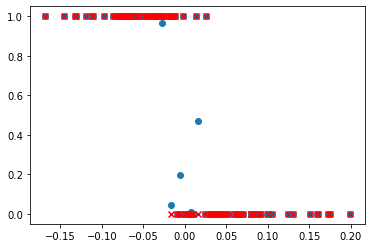

In [38]:
X_1 = np.mean(X, 1)
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(X_1,p[:,1]) 
ax.scatter(X_1,y[:,1],marker="x", color="red")

# pourquoi X est centré sur 0 ? l'ordre de grandeur de X ne correspond pas à une e de -30:30 avec des W -3:3...

Meme les probabilités de classification des entrées sont beaucoup plus ordonnées. Quasi toutes les entrées ont été classifié avec ' assurance '.

__On peut donc élaborer des poids intéressant à partir des probabilités de sortie.__

In [ ]:
X, p, y, e = get_data(W, X, seed=seed, N_batch=1000000) 
logistic_model, loss = fit_data(X, y, verbose=True) #apprentissage avec W fixé à partir de p 
print("Final loss =", loss)

Iteration: 0 - Loss: 0.06401
Iteration: 16 - Loss: 0.01685
Iteration: 32 - Loss: 0.01442
Iteration: 48 - Loss: 0.01332
Iteration: 64 - Loss: 0.01267
Iteration: 80 - Loss: 0.01224
Iteration: 96 - Loss: 0.01194
Iteration: 112 - Loss: 0.01171
Iteration: 128 - Loss: 0.01153
Iteration: 144 - Loss: 0.01139
Iteration: 160 - Loss: 0.01127
Iteration: 176 - Loss: 0.01117
Iteration: 192 - Loss: 0.01110
Iteration: 208 - Loss: 0.01102
Iteration: 224 - Loss: 0.01097
Iteration: 240 - Loss: 0.01093


On réentraine notre réseau pour qu'il apprenne à classer les entrées de la même façon que pendant la nouvelle initialisation. Pour se rapprocher du nouveau y, il faudra qu'il apprenne les nouveaux poids qu'on a implémentés. 

L'apprentissage est meilleur en augmentant le batch
Il faut quand même 1 000 000 de batch pour que l'apprentissage soit ok, pourquoi ? alors que pour le premier apprentissage, il ne suffisait que de 1000 batch ? est ce qu'on pourrait changer des paramètres pour l'améliorer ? 

### Visualisation de l'apprentissage des poids 

Visualisation des poids appliqués à la classe 2 pdt l'initialisation et après apprentissage

Text(0.5, 0, 'address')

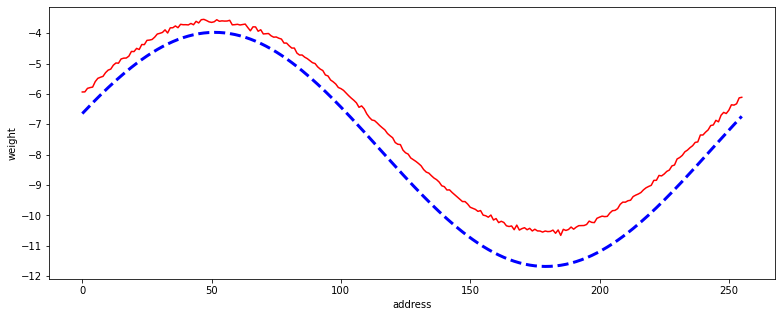

In [47]:
i_digit = 2 
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[:-1, i_digit], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')
ax.set_ylabel('weight')
ax.set_xlabel('address')

Visualisation des poids de toutes les classes pdt initialisation et après apprentissage

Text(0.5, 0, 'address')

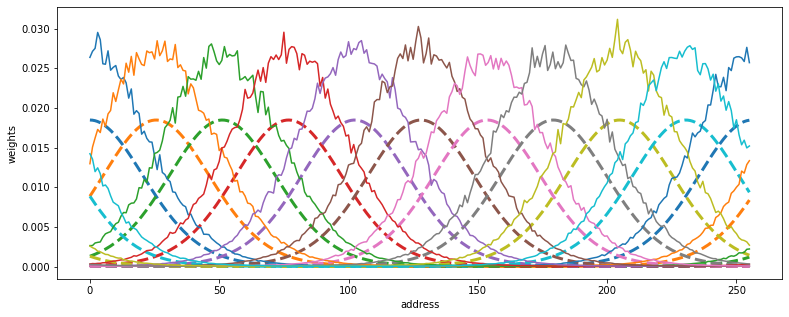

In [49]:
#pourquoi les faire passer dans des sigmoides ? 

fig, ax = plt.subplots(figsize=figsize)
ax.plot(sigmoid(W[:-1, :]), '--', lw=3)
ax.plot(sigmoid(logistic_model.linear.weight[:, :].detach().numpy().T), '-')
ax.set_ylabel('weights')
ax.set_xlabel('address')

Text(0.5, 0, 'address')

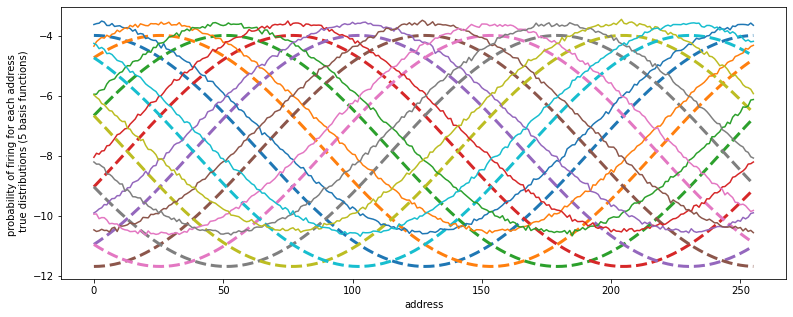

In [50]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(W[:-1, :], '--', lw=3)
ax.plot(logistic_model.linear.weight[:, :].detach().numpy().T, '-')
ax.set_ylabel('probability of firing for each address \n true distributions (5 basis functions)')
ax.set_xlabel('address')

Là où il ya des fortes probabilités de firing, il y a de forst poids. Pour l'instant, les poids fixés et les poids appris ont la même allure et la même proportionalité mais ils n'ont pas le même ordre de grandeur

--------------------------------------------------------------------

Avec des rasters plots synthetiques, on pourra connaître les probabilités de firing des neurones en fonction des groupes polychrones. A partir de cette sortie, on pourra déterminer des poids optimaux pour la classification des entrées. On entrainera notre réseau de sorte à ce qu'il aprenne à appliquer ces poids à ses entrées afin de reconnaitre l'occurrence d'un groupe polychrone. 
-> __APPRENTISSAGE SUPERVISE__


Avec cette technique, on connait le pattern des groupes polychrones. Si on veut chercher dans des données, l'occurence de ces groupes polychrones sans que nous sachions à quel moment est ce qu'ils arrivent, il y a de grande chance pour que la detection (ou alors à partir de ça on fera un apprentissage ?) soit efficace et qu'on connaisse le moment d'occurrence des PGs.


-> Je pensais rapprocher cette idée à l'__apprentissage semi suppervisé__ mais je ne comprends pas __1.__ où est l'apprentissage, __2.__ à partir de quoi se fait il ? Comment le réseau apprend ce qui est bon ou mauvais ? 

